#  GENOM PROJECT 2020-2021

## Kmer computation in Horizontal transfert origin prediction
#### Alex Lence, Simon Chardin, Adrien Leroy

This project is the **second** part of the project and shows how we predicted the origin of Kmer signature from horizontal transfers from K-Mer signatures using **kython** and a hard coded Fully connected neural network.

[Kython on Github](https://www.github.com/LeroyAdrien/Kython), [Kython on testPypi](https://test.pypi.org/project/kython/)

<img src='TOL_notebook.png' title="Tree from Archaeas and Bacterias">&nbsp;

##### This notebook shows:

* **Module pp**
    * Preparing Data for the training of the neural network
   
* **Module pl**


In [1]:
from kython import pp,pl
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import chi2_contingency
from os import listdir
from os.path import isfile, join
import pandas as pd
import random as rd

### I-Retrieving organisms names linked to their .fna files

We used a nested dictionnary to be able to retrieve phylums, organism names and genomin .fna file path



**Structure is the following:** $\color{black}{\text{Dictionnary}}$**\[**$\color{blue}{\text{Phylum}}$**\]\[**$\color{blue}{\text{Organism}}$**\]=**$\color{red}{\text{'Path to Genomic File'}}$

#### Setting up paths 

In [2]:
bacteriaListPath='../data/Bacteria.list'
archaeaListPath='../data/Archea.list'
resultsfolder='./refseq/'

In [3]:
pathDictionnary=pp.ParseSequences(resultsfolder)

#### We retreived the following organisms:

In [4]:
print("Bacterias:",'\n')
for bacteria in pathDictionnary['bacteria'].keys():
    print(bacteria)
print("\n")

print("Archaeas:",'\n')
for archaea in pathDictionnary['archaea'].keys():
    print(archaea)

Bacterias: 

Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_6119_chromosome_CBM2610_a
Methylacidiphilum_infernorum_V4
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_SWF_66322_
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_8558_chromosome_CBM2615_a
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_3679_
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_ip2.30/pp_2.30_chromosome_CBM2623_a
Coxiella_burnetii_RSA_493
Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir
Mycoplasma_genitalium_G37
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_3521_chromosome_CBM2589_a
Bacteroides_fragilis_YCH46
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_3511_chromosome_CBM2588_a
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_8561_chromosome_CBM2618_a
Thermotoga_maritima_MSB8
Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_mpp_1.3_chromosome_CBM2625_a
Nostoc_punctiforme_PCC_73102
Bordetella_pertussis_

### II-Building the Neural network

#### a-Classes

In [5]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward_propagation(self,input):
        raise NotImplementedError
        
    def backward_propagation(self,output_error, learning_rate):
        raise NotImplementedError

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

    
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error
    
    

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            #print('epoch %d/%d   error=%f' % (i+1, epochs, err))

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;
            
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

#### b-Functions

In [ ]:
def def_matrice_learn(supermatrice):
    "Initialization of learning's matrix and label from the GatherTrainingData file"
    Y_learn=[]
    X_learn=[]
    for i in range(len(supermatrice)):
        if len(supermatrice[i])>=50:
            for j in range(50):
                y_learn=np.zeros(len(supermatrice))
                y_learn[i]=1
                Y_learn.append(y_learn)
                X_learn.append([supermatrice[i][j]])
        else:
            for j in range(len(supermatrice[i])):
                y_learn=np.zeros(len(supermatrice))
                y_learn[i]=1
                Y_learn.append(y_learn)
                X_learn.append([supermatrice[i][j]])
                
    return(np.array(X_learn),np.array(Y_learn))
 

def nom_organisme(inputPath):
    "Creat list of species and the supermatrix that concatenate all the kmer signature "
    supermatrice=[]
    liste_org=[]
    fichiers = [f for f in listdir(inputPath) if isfile(join(inputPath, f))]
    for org in fichiers:
        try:
            data=pd.read_csv(inputPath+"/"+org)
            org=org.split("_")[1]
            org=org.split(".")[0]
            liste_org.append(org)
            supermatrice.append(data.values)
        #If a file is empty
        except ValueError:
            pass
    return(liste_org,np.array(supermatrice))

def FindOrganism(kmer: int, kmersignature:list, inputPath:str,train=True)->str:
    liste_org,supermatrice=nom_organisme(inputPath)
    X_learn,Y_learn=def_matrice_learn(supermatrice)
    
    # Network
    net = Network()
    net.add(FCLayer(4**kmer, 300))                # input_shape=(1, 4**kmer)    ;   output_shape=(1, 300)
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(300, 200))                   # input_shape=(1, 300)      ;   output_shape=(1, 200)
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(200, 128))                   # input_shape=(1, 200)      ;   output_shape=(1, 128)
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(128,len(liste_org)))          # input_shape=(1, 128)      ;   output_shape=(1, len(liste_org))         
    net.add(ActivationLayer(tanh, tanh_prime))

    
    #Function use for forward and backward activation 
    net.use(mse, mse_prime)
    
    #Shuffle the learning matrix and the label matrix as the same
    rd.seed(0)
    rd.shuffle(X_learn)
    rd.seed(0)
    rd.shuffle(Y_learn)
    
    
    #Fit the network on the data from GatherTrainingData file
    if train==True:
        net.fit(X_learn, Y_learn, epochs=10, learning_rate=0.1)

    #Predict the species from kmersignature
    out = net.predict(kmersignature)
    print(liste_org[np.argmax(out)])
    return(liste_org[np.argmax(out)])

### III-Application : Organism of interest 

Bacteria: Coxiella burnetii RSA 493



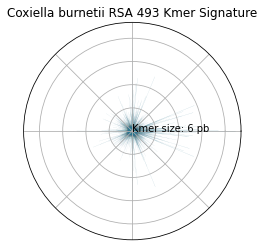

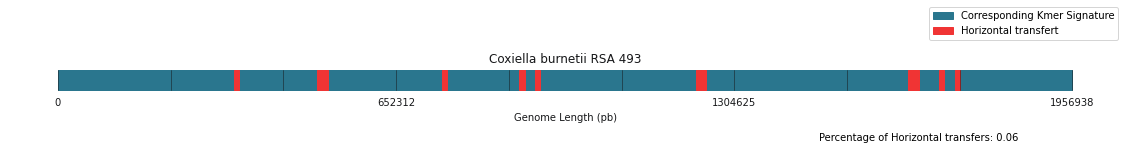

In [18]:
print("Bacteria: Coxiella burnetii RSA 493")

signature=pp.KmerSignature(pathDictionnary["bacteria"]["Coxiella_burnetii_RSA_493"],6,False)
pl.KmerSignature(signature,"Coxiella burnetii RSA 493")

listPvalue,listPositions=pp.SequenceHomogeneity(pathDictionnary["bacteria"]["Coxiella_burnetii_RSA_493"],6,10000)
pl.SequenceHomogeneity(listPvalue,listPositions,0.05,"Coxiella burnetii RSA 493")

### IV- Applying the network on a given organism

#### Preparing Data <u> (about 45 minutes Long on i5 7200 U and 6Gb RAM)

In [ ]:
pp.GatherTrainingData(pathDictionnary,6,20000,'../data/training_data',0.05,'bacteria')

Gathering Training Data from:  Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_6119_chromosome_CBM2610_a
Number of Samples Gathered: 43
Size of file: 1409136
Gathering Training Data from:  Methylacidiphilum_infernorum_V4
Number of Samples Gathered: 51
Size of file: 1671280
Gathering Training Data from:  Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_SWF_66322_
Number of Samples Gathered: 42
Size of file: 1376368
Gathering Training Data from:  Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_8558_chromosome_CBM2615_a
Number of Samples Gathered: 31
Size of file: 1015920
Gathering Training Data from:  Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_3679_
Number of Samples Gathered: 0
Size of file: 96
Gathering Training Data from:  Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_ip2.30/pp_2.30_chromosome_CBM2623_a
Number of Samples Gathered: 0
Size of file: 96
Gathering Training Data from:  Coxiella_burnetii_RSA_493
Number of Samples Gath

#### Training the Network

In [ ]:
def FindHorizontalTransfers(path:str,kmer:int,fragmentSize:int,seuil:float):
        """Compute the Homogeneity of a sequence and spots any horizontal transfers """
        #Retrieve sequence and dictionnary
        globalSignature=pp.KmerSignature(path,kmer,False)
        sequence=pp.Read_Sequence(path)
        
        #List of values
        listepval = []
        listepos= [0]
        listOrigins=[]
        pos=0
        train=True
        
        while pos<len(sequence):
                """
                if int(pos/len(sequence)*100)%5==0:
                        print((pos/len(sequence))*100,"%")
                """
                #Cuts sequence fragment
                sequenceFragment=sequence[pos:pos+fragmentSize]
                seqCut = [sequenceFragment[i:i+kmer] for i in range(len(sequenceFragment)-(kmer-1)) ]
                
                #Retrieve signature of fragment
                fragmentSignature = pp.Count_Cuts(seqCut,False)
                
                #Create contingency table
                contingency=np.concatenate((globalSignature.values+1,fragmentSignature.values+1),axis=0)
                
                
                resultat,pval, dof, expctd = chi2_contingency(contingency)
                
                if pval<seuil:
                    organismFound=FindOrganism(kmer,list(fragmentSignature.values),'../data/training_data',train)
                    train=False
                    listOrigins.append(organismFound)
                    


                if pos+fragmentSize>len(sequence):
                        fragmentSize=len(sequence)-pos
                        pos+=fragmentSize
                else:
                        pos+=fragmentSize
                        
                #Add new position
                listepos.append(pos)

        return listepval,listepos,listOrigins

#### Applying the network on an organism

In [ ]:
listepVal,listepos,listOrigins=FindHorizontalTransfers(pathDictionnary["bacteria"]["Coxiella_burnetii_RSA_493"],6,20000,0.05)

#### Retrieving the results

In [ ]:
listOrigins